In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import *
from tqdm import tqdm
%matplotlib inline
from scipy.interpolate import Rbf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def P0(alpha, beta):
    return np.exp(-abs(alpha + beta)**2)

def Ptot0(eta,alpha,beta):
    return eta*P0(alpha,beta) + (1-eta)*P0(-alpha,beta)

def Poutcome(n,alpha,beta):
    if n==0.:
        return P0(alpha, beta)
    elif n==1.:
        return 1-P0(alpha,beta)
    else:
        return None
    
def Ptot_outcome(n,eta,alpha,beta):
    if n==0.:
        return Ptot0(eta,alpha, beta)
    elif n==1.:
        return 1.-Ptot0(eta,alpha,beta)
    else:
        return None

def postirior(ot,prior,alpha,beta):
    return prior*Poutcome(ot,alpha,beta)/Ptot_outcome(ot,prior,alpha,beta)

def attenuations(L):
    ats=[np.pi/2]
    for i in range(1,L):
        ats.append(np.arctan(1/np.sqrt(i)))
    return np.array(ats[::-1])

def reward_function(eta):
    return max(eta,1-eta)

In [35]:
def s_function0(beta, alpha, eta):
    beta = beta[0]
    s=0
    for n in [0.,1.]:
        s+=Ptot_outcome(n,eta, alpha/np.sqrt(2), beta)*reward_function(postirior(n, eta, alpha/np.sqrt(2), beta))
    return 1-s

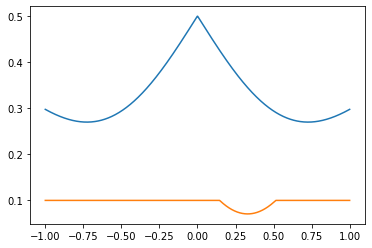

In [36]:
betas = np.linspace(-1,1,1000)
ss = [s_function0([b],0.4,.5) for b in betas]
ss1 = [s_function0([b],0.4, .1) for b in betas]

plt.plot(betas,ss)
plt.plot(betas,ss1)

In [37]:
N=50
alphas = np.linspace(0,1,N)
etas = np.linspace(0,.5,N)
betas = np.linspace(-1,1,100)


s0=np.zeros((len(alphas), len(etas)))
fun0=np.zeros((len(alphas), len(etas)))

for inda, a in tqdm(enumerate(alphas)):
    for ine, et in enumerate(etas):
        if inda==0.:
            s0[inda,ine]= 0.5
        elif ine ==0.:
            s0[inda,ine]=1.
        else:
            sidi = betas[np.argmin([s_function0([b],a,et) for b in betas])]
            ff = minimize(s_function0,x0=sidi, args=(a,et),bounds=[tuple([None, None])])#method="BFGS",options={"maxiter":1e5,"gtol":1e-7})
            s0[inda,ine]= 1-ff.fun
            fun0[inda,ine]= ff.x
        
        

50it [00:06,  7.52it/s]


In [38]:
def interpolationn(alpha,eta,rbfint):
    if isinstance(eta,np.ndarray):
        eta = np.where(eta<=.5,eta,1-eta)
        return rbfint(alpha, eta)
    else:
        if eta>.5:
            eta = 1-eta
        return rbfint(alpha,eta)

In [51]:
def s_function1(beta, alpha,eta, rbfmod):
    beta = beta[0]
    s=0
    for n in [0.,1.]:
        s+=Ptot_outcome(n,eta, alpha, beta)*interpolationn(alpha/np.sqrt(2), postirior(n, eta, alpha/np.sqrt(2), beta), rbfmod)
    return 1-s

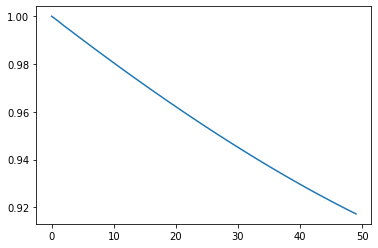

In [52]:
alphas1, etas1 = np.meshgrid(alphas,etas)
mod0 = Rbf(etas1,alphas1/np.sqrt(2),s0)
plt.plot([mod0(0.4,eta) for eta in etas])

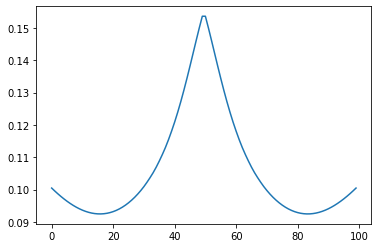

In [53]:
a, et = 0.4, .5
at = np.pi/4
plt.plot([s_function1([b],a,et, mod0) for b in betas])

In [54]:
s1=np.zeros((len(alphas), len(etas)))
fun1=np.zeros((len(alphas), len(etas)))

for inda, a in tqdm(enumerate(alphas)):
    for ine, et in enumerate(etas):
        
        if inda==0.:
            s1[inda,ine]= 0.5
        elif ine ==0.:
            s1[inda,ine]=1.
        else:
            sidi = betas[np.argmin([s_function1([b],a,et, mod0) for b in betas])]

            ff = minimize(s_function1,x0=sidi, args=(a,et, mod0),bounds=[tuple([None, None])])
            s1[inda,ine]= 1-ff.fun
            fun1[inda,ine]= ff.x
      

50it [00:41,  1.21it/s]


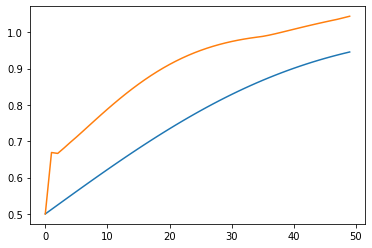

In [55]:
plt.plot(s0[:,49])
plt.plot(s1[:,49])

In [89]:
alphas1, etas1 = np.meshgrid(alphas,etas)


In [92]:
s0[-1,:]

array([       nan, 0.99993055, 0.99985969, 0.99978737, 0.99971355,
       0.9996382 , 0.99956127, 0.99948271, 0.99940249, 0.99932054,
       0.99923684, 0.99915131, 0.99906392, 0.99897461, 0.99888332,
       0.99879   , 0.99869458, 0.99859702, 0.99849724, 0.99839518,
       0.99829079, 0.99818398, 0.99807469, 0.99796286, 0.9978484 ,
       0.99773124, 0.99761131, 0.99748852, 0.9973628 , 0.99723406,
       0.99710223, 0.9969672 , 0.9968289 , 0.99668724, 0.99654212,
       0.99639346, 0.99624115, 0.99608511, 0.99592523, 0.99576143,
       0.9955936 , 0.99542165, 0.99524548, 0.99506498, 0.99488008,
       0.99469065, 0.99449663, 0.9942979 , 0.99409438, 0.99388598])

ValueError: array must not contain infs or NaNs

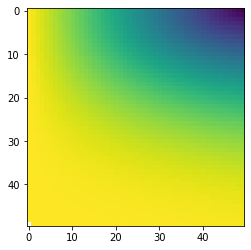

In [87]:
plt.imshow(s0)

ValueError: array must not contain infs or NaNs

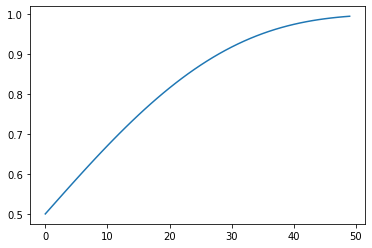

In [84]:
from scipy.interpolate import Rbf

alphas1, etas1 = np.meshgrid(alphas,etas)
mod0 = Rbf(etas1,alphas1,s0)

fig=plt.figure()
im = plt.contour(alphas,etas,mod0(etas1,alphas1) - s0)
fig.colorbar(im)
